In [24]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score
)

import warnings
warnings.filterwarnings("ignore")

### Checking to see what features are in the csv

In [25]:

df = pd.read_csv('cleaned_pfas_cancer_merged.csv')
print(df.head())
print("\nAvailable Features:")
print(df.columns.tolist())
print("\nMissing values per column:")
print(df.isna().sum())


    county gm_samp_collection_date   10:2FTS  11ClPF3OUDS   3:3FTCA    4:2FTS  \
0  Alameda              2018-09-11  1.200595     1.120463  1.658471  2.179993   
1  Alameda              2018-09-11  1.200595     1.120463  1.658471  2.179993   
2  Alameda              2018-09-11  1.200595     1.120463  1.658471  2.179993   
3  Alameda              2018-09-11  1.200595     1.120463  1.658471  2.179993   
4  Alameda              2018-09-11  1.200595     1.120463  1.658471  2.179993   

    5:3FTCA    6:2FTS   7:3FTCA    8:2FTS  ...     PFPES    PFTEDA   PFTRIDA  \
0  1.485784  7.667568  1.847953  4.009532  ...  4.951307  1.458615  1.458615   
1  1.485784  7.667568  1.847953  4.009532  ...  4.951307  1.458615  1.458615   
2  1.485784  7.667568  1.847953  4.009532  ...  4.951307  1.458615  1.458615   
3  1.485784  7.667568  1.847953  4.009532  ...  4.951307  1.458615  1.458615   
4  1.485784  7.667568  1.847953  4.009532  ...  4.951307  1.458615  1.458615   

    PFUNDCA  total_pfas_concentr

In [26]:
numeric_df = df.select_dtypes(include='number')
correlations = numeric_df.corr()['AAIR'].dropna()
exclude = ['total_pfas_concentration', 'PopTot', 'Cancer_Incidents', 'AAIR']
chemical_correlations = correlations.drop(labels=exclude, errors='ignore')
top_10_chemicals = chemical_correlations.abs().sort_values(ascending=False).head(10)

print("Top 10 PFAS chemicals correlated with AAIR:")
print(top_10_chemicals)

Top 10 PFAS chemicals correlated with AAIR:
ETFOSE      0.027860
MEFOSE      0.025227
PFHXDA      0.019045
ETFOSA      0.014508
MEFOSA      0.012733
PFUNDCA     0.012703
PFDOA       0.011038
PFNS        0.010826
NMEFOSAA    0.010358
NETFOSAA    0.010175
Name: AAIR, dtype: float64


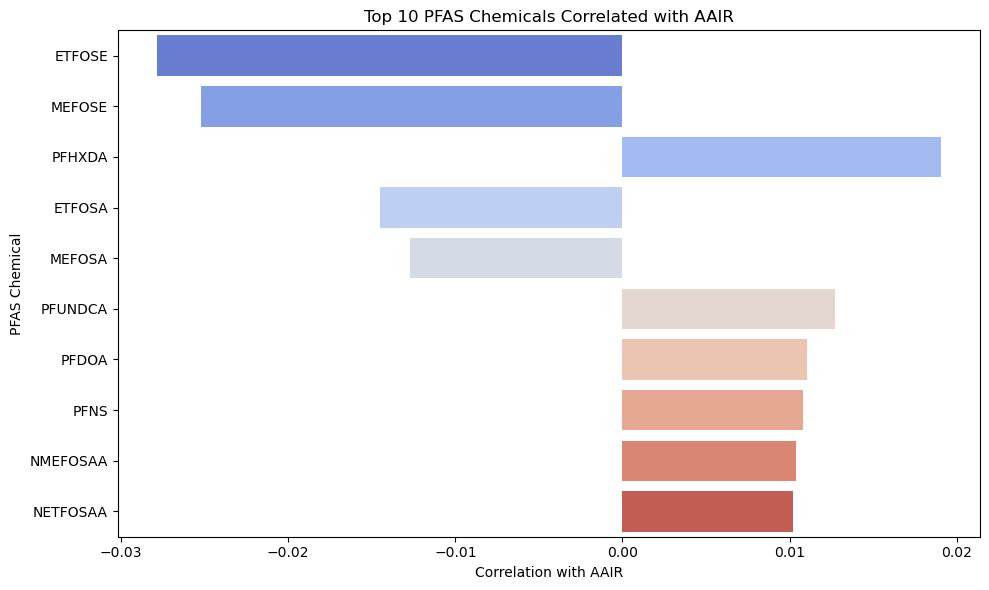

In [27]:
# Sort the top 10 chemicals with actual (signed) correlations
top_10_corr = chemical_correlations.loc[top_10_chemicals.index]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_corr.values, y=top_10_corr.index, palette='coolwarm')
plt.title("Top 10 PFAS Chemicals Correlated with AAIR")
plt.xlabel("Correlation with AAIR")
plt.ylabel("PFAS Chemical")
plt.tight_layout()
plt.show()

### Extracting the top 10 Chemicals


In [28]:

top_10_chemicals_list = top_10_corr.index.tolist()

non_chemical_columns = [
    'county',
    'gm_samp_collection_date',
    'total_pfas_concentration',
    'Cancer_Incidents',
    'AAIR',
    'PopTot',
    'Sex',
    'Cancer'
]

reduced_df = df[top_10_chemicals_list + non_chemical_columns]

 ### One-Hot Encoding + Binary Label Creation + Data Preparation

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

encoded_df = pd.get_dummies(reduced_df, columns=['Sex', 'Cancer'], drop_first=True)

# Create AAIR binary label
mean_aair = encoded_df['AAIR'].mean()
encoded_df['AAIR_Label'] = (encoded_df['AAIR'] > mean_aair).astype(int)

# Save the encoded dataframe with all features
encoded_df.to_csv("reduced_pfas_dataset.csv", index=False)

# Prepare features and labels for ML
features_to_drop = ['AAIR', 'Cancer_Incidents', 'gm_samp_collection_date', 'county']
X = encoded_df.drop(columns=features_to_drop + ['AAIR_Label'])
y = encoded_df['AAIR_Label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)



### Train + Evaluate Random Forest Classifier


Model Results:
Accuracy: 0.9102449223416965
Confusion Matrix:
 [[16784     0]
 [ 1803  1501]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     16784
           1       1.00      0.45      0.62      3304

    accuracy                           0.91     20088
   macro avg       0.95      0.73      0.79     20088
weighted avg       0.92      0.91      0.90     20088



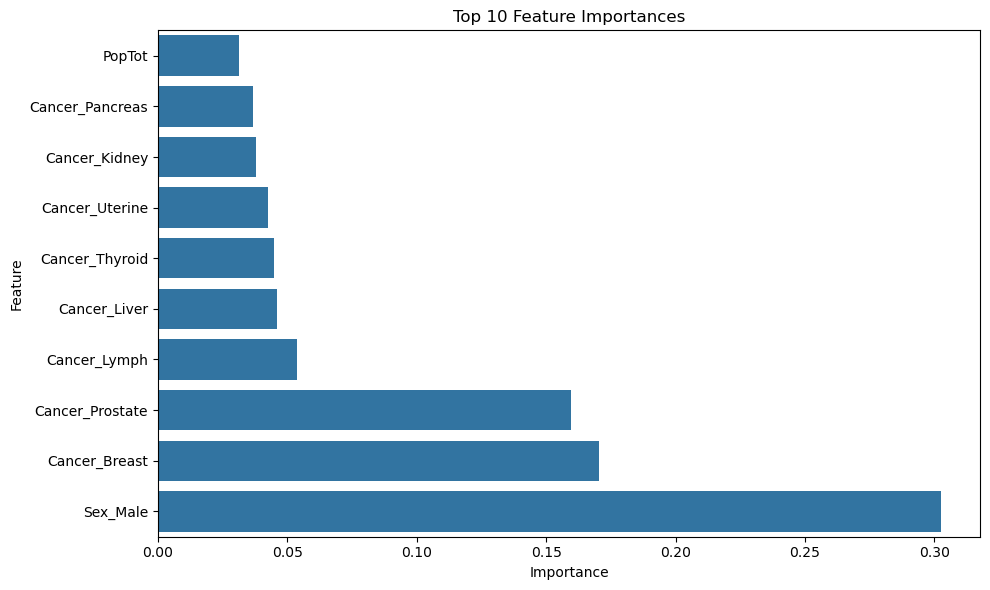

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# train a Random Forest Classifier
clf = RandomForestClassifier(
    random_state=50,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=5,
    n_estimators=100
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Model Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# plot 10 most important features
importances = clf.feature_importances_
feature_names = X.columns
top_indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[top_indices], y=np.array(feature_names)[top_indices])
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Logistic Regression (L1) Results:
Accuracy: 0.9137378283119935
Confusion Matrix:
 [[39936  2042]
 [ 2290  5951]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     41978
           1       0.74      0.72      0.73      8241

    accuracy                           0.91     50219
   macro avg       0.85      0.84      0.84     50219
weighted avg       0.91      0.91      0.91     50219



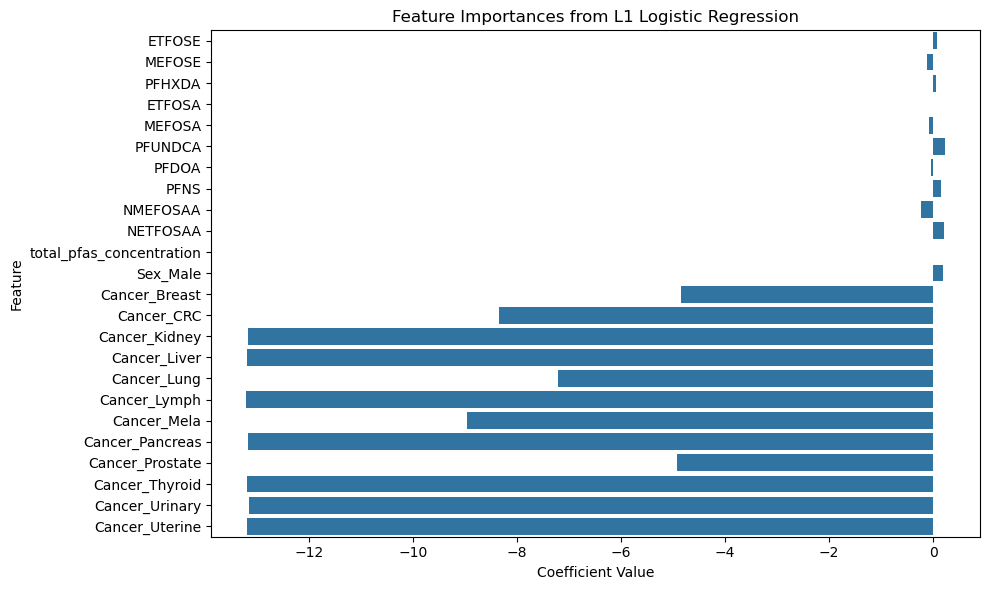

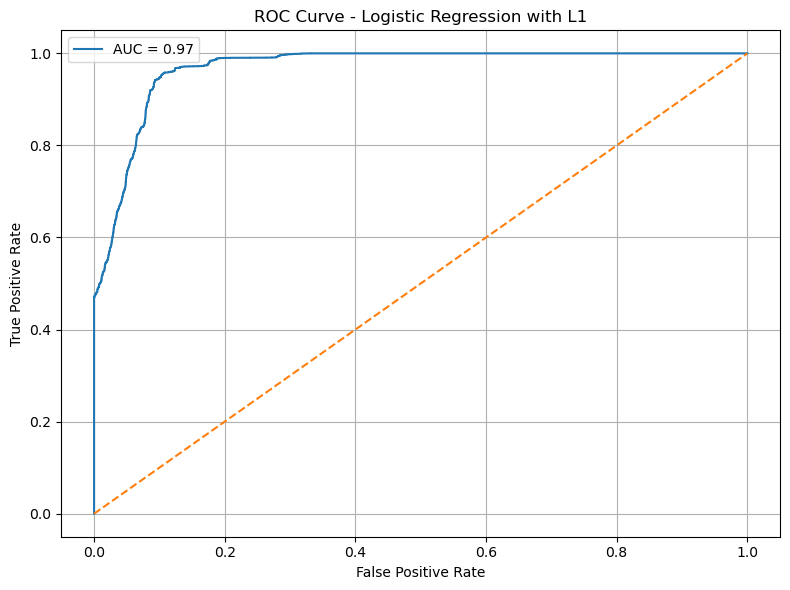

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare features (use all features: chemicals + Sex + Cancer, like you said)
features_to_drop = ['AAIR', 'Cancer_Incidents', 'gm_samp_collection_date', 'county']
X = encoded_df.drop(columns=features_to_drop + ['AAIR_Label'])
y = encoded_df['AAIR_Label']

# Split (no scaling, raw features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Train Logistic Regression with L1 regularization
log_reg = LogisticRegression(
    penalty='l1',          # L1 regularization
    solver='liblinear',    # solver that supports L1
    C=1.0,                 # regularization strength (smaller C = stronger regularization)
    random_state=50
)

log_reg.fit(X_train, y_train)

# Predict
y_pred = log_reg.predict(X_test)

# Evaluation
print("Logistic Regression (L1) Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importance (non-zero coefficients)
coef = log_reg.coef_[0]
feature_names = X.columns

# Only show features that survived (non-zero)
non_zero_features = feature_names[np.abs(coef) > 1e-6]
non_zero_coefs = coef[np.abs(coef) > 1e-6]

plt.figure(figsize=(10, 6))
sns.barplot(x=non_zero_coefs, y=non_zero_features, orient='h')
plt.title("Feature Importances from L1 Logistic Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Optional: Plot ROC Curve
y_pred_proba = log_reg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.2f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression with L1')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



Confusion Matrix for Logistic Regression

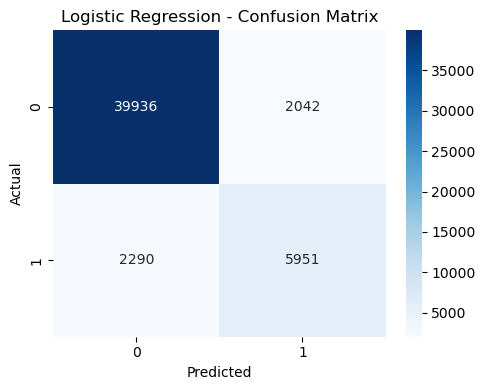

In [38]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_logistic = log_reg.predict(X_test)

cm_logistic = confusion_matrix(y_test, y_pred_logistic)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Confusion Matrix for Random Forest

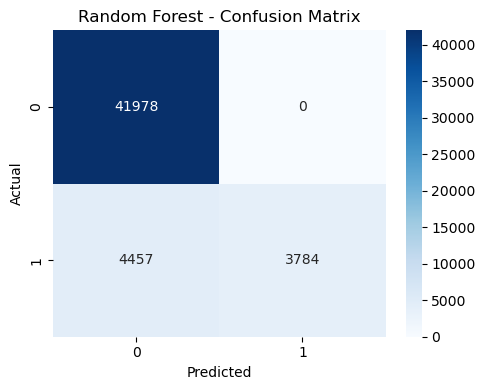

In [40]:
y_pred_rf = clf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()